<a href="https://colab.research.google.com/github/OttoJursch/DRL_robot_exploration/blob/master/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install pybind11
!git clone https://github.com/pybind/pybind11.git
!cd pybind11 && mkdir build && cd build && cmake .. && make install

Cloning into 'pybind11'...
remote: Enumerating objects: 13942, done.
remote: Total 13942 (delta 0), reused 0 (delta 0), pack-reused 13942
Receiving objects: 100% (13942/13942), 5.40 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (9492/9492), done.
-- The CXX compiler identification is GNU 7.5.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- pybind11 v2.6.2 dev1
-- CMake 3.12.0
-- Found PythonInterp: /usr/bin/python3.6 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- PYTHON 3.6.9
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- pybind11::lto enabled
-- pybind11::thin_lto enabled
-- Setting tests build type to MinSizeRel as none was specified
-- Building tests WITHOUT Eigen, use -DDOWNLOAD_EIGEN on CMake 3.11+ to do

In [2]:
#Install Eigen
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 1s (1,259 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...


In [3]:
# Install dependencies on colab
!git clone https://github.com/OttoJursch/DRL_robot_exploration.git

Cloning into 'DRL_robot_exploration'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11335 (delta 2), reused 0 (delta 0), pack-reused 11326
Receiving objects: 100% (11335/11335), 322.75 MiB | 37.12 MiB/s, done.
Resolving deltas: 100% (258/258), done.
Checking out files: 100% (10924/10924), done.


In [4]:
!#Build the C++/pybind stuff
!rm -rf DRL_robot_exploration/build
!cd DRL_robot_exploration && mkdir build && cd build && cmake .. && make

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found PythonInterp: /usr/bin/python3 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Found pybind11: /usr/local/include (found version "2.6.2" dev1)
-- Configuring done
-- Generating done
-- Build files have been written to: /content/DRL_robot_exploration/build
Scanning dependencies of target

In [5]:
!cd DRL_robot_exploration && git pull

Already up to date.


In [6]:
#laptop=True
laptop=False

In [7]:
from copy import deepcopy

class PaperRewardFunction:
    '''
    Reward function from the paper
    '''
    def __init__(self):
        pass

    def get_reward(self, robot_position, old_op_map, op_map, coll_index):
        '''
        Takes in map before step and map after step. Measures effect of sensor
        input from last step
        '''
        if not coll_index:
            reward = float(
                np.size(np.where(op_map == 255)) - np.size(np.where(old_op_map == 255))) / 14000
            if reward > 1:
                reward = 1
        else:
            reward = -1
        return reward


class FrontierRewardFunction:
    def __init__(self, reward_scale):
        self.reward_scale = reward_scale
        self.paper_reward = PaperRewardFunction()

    def frontiers(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]

        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def get_reward(self, robot_pos, old_op_map, op_map, coll_index):
        paper_reward = self.paper_reward.get_reward(robot_pos, old_op_map,
                                                    op_map, coll_index)

        #If there was a collision return the collision reward
        if coll_index:
            return paper_reward

        frontiers = np.array(
            self.frontiers(op_map, op_map.shape, self.map_points(op_map)))

        min_frontier_dist = -np.min(np.linalg.norm(robot_pos - frontiers, axis=1))
        return self.reward_scale * min_frontier_dist + paper_reward

sqrt2 = 2**0.5 +0.1
class PolarActionSpace:
    '''
    Action space is polar representation of vector robot should take from its
    current position

    This class will take that and add it to the current robot position to get 
    '''
    def __init__(self, min_travel, max_travel):
        self.max_distance = max_travel
        self.min_travel = min_travel

    def get_action(self, action_polar_coords, robot_position):
        angle = action_polar_coords[0] * (2 * np.pi)
        dist = action_polar_coords[1] * (self.max_distance - self.min_travel) + self.min_travel
        dx = dist * np.sin(angle)
        dy = dist * np.cos(angle)

        return np.array([dx, dy])


In [8]:
from scipy import spatial
from skimage import io
import numpy as np
import numpy.ma as ma
import time
import sys
from scipy import ndimage
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.append('DRL_robot_exploration')
if laptop:
    from build.inverse_sensor_model import *
    from build.astar import *
else:
    from DRL_robot_exploration.build.inverse_sensor_model import *
    from DRL_robot_exploration.build.astar import *
from random import shuffle
import os
import random


class Robot:
    def __init__(self,
                 index_map,
                 train,
                 plot,
                 root_dir,
                 action_space,
                 reward_function,
                 do_rescue,
                 shuffle=True):
        self.mode = train
        self.action_space = action_space
        self.plot = plot
        self.root_dir = root_dir
        self.index_map = index_map
        self.do_rescue = do_rescue
        self.reward_function = reward_function
        self.reset(index_map, shuffle)

    def reset(self, index_map=None, do_shuffle=True):
        if self.mode:
            self.map_dir = os.path.join(self.root_dir, 'train')
        else:
            self.map_dir = os.path.join(self.root_dir, 'test')
        self.map_list = os.listdir(self.map_dir)
        self.map_number = np.size(self.map_list)
        if self.mode and do_shuffle:
            shuffle(self.map_list)
        if index_map is None:
            index_map = random.choice(range(len(self.map_list)))
        self.li_map = index_map
        self.global_map, self.robot_position = self.map_setup(
            self.map_dir + '/' + self.map_list[self.li_map])
        self.op_map = np.ones(self.global_map.shape) * 127
        self.map_size = np.shape(self.global_map)
        self.finish_percent = 0.985
        self.resolution = 1
        self.sensor_range = 80
        self.old_position = np.zeros([2])
        self.old_op_map = np.empty([0])
        #current_dir = os.path.dirname(os.path.realpath(__file__))
        self.t = self.map_points(self.global_map)
        self.free_tree = spatial.KDTree(
            self.free_points(self.global_map).tolist())
        self.robot_size = 6
        self.local_size = 40
        if self.plot:
            self.xPoint = np.array([self.robot_position[0]])
            self.yPoint = np.array([self.robot_position[1]])
            self.x2frontier = np.empty([0])
            self.y2frontier = np.empty([0])


        return self.begin(), self.robot_position

    def begin(self):
        self.op_map = self.inverse_sensor(self.robot_position,
                                          self.sensor_range, self.op_map,
                                          self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size,
                                    self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)
        if self.plot:
            self.plot_env()
        return self.op_map

    def step(self, action_index):
        terminal = False
        complete = False
        new_location = False
        all_map = False
        self.old_position = self.robot_position.copy()
        self.old_op_map = self.op_map.copy()

        # take action
        self.take_action(action_index, self.robot_position)

        # collision check
        collision_points, collision_index = self.collision_check(
            self.old_position, self.robot_position, self.map_size,
            self.global_map)

        if collision_index:
            self.robot_position = self.nearest_free(self.free_tree,
                                                    collision_points)
            self.op_map = self.inverse_sensor(self.robot_position,
                                              self.sensor_range, self.op_map,
                                              self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size,
                                        self.t, self.op_map)
        else:
            self.op_map = self.inverse_sensor(self.robot_position,
                                              self.sensor_range, self.op_map,
                                              self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size,
                                        self.t, self.op_map)

        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)
        reward = self.reward_function.get_reward(self.robot_position,
                                                 self.old_op_map, self.op_map,
                                                 collision_index)

        if reward <= 0.02 and not collision_index:
            reward = -0.8
            new_location = True
            #terminal = True

        # during training, the robot is relocated if it has a collision
        # during testing, the robot will use collision check to avoid the collision
        if collision_index:
            if not self.mode:
                new_location = False
                terminal = False
            else:
                new_location = True
                terminal = True
            if self.plot and self.mode:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()
            self.robot_position = self.old_position.copy()
            self.op_map = self.old_op_map.copy()
            if self.plot and self.mode:
                self.xPoint[self.xPoint.size - 1] = ma.masked
                self.yPoint[self.yPoint.size - 1] = ma.masked
        else:
            if self.plot:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()

        # check if exploration is finished
        if np.size(np.where(self.op_map == 255)) / np.size(
                np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            #self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True

        return (
            self.op_map, self.robot_position
        ), reward, terminal, complete, new_location, collision_index, all_map

    def rescuer(self):
        complete = False
        all_map = False
        pre_position = self.robot_position.copy()
        robot_position = self.frontier(self.op_map, self.map_size, self.t)[0]
        op_map = self.inverse_sensor(robot_position,
                                          self.sensor_range, self.op_map,
                                          self.global_map)

        path = self.astar_path(self.op_map, pre_position.tolist(),
                                   robot_position.tolist())
        #if self.plot:
        #  self.plot_env()
        #  self.x2frontier = ma.append(self.x2frontier, ma.masked)
        #  self.y2frontier = ma.append(self.y2frontier, ma.masked)
        #  self.x2frontier = ma.append(self.x2frontier, path[1, :])
        #  self.y2frontier = ma.append(self.y2frontier, path[0, :])
        #  self.xPoint = ma.append(self.xPoint, ma.masked)
        #  self.yPoint = ma.append(self.yPoint, ma.masked)
        #  self.xPoint = ma.append(self.xPoint, self.robot_position[0])
        #  self.yPoint = ma.append(self.yPoint, self.robot_position[1])

        return op_map, path

    def take_action(self, action_index, robot_position):
        move_action = self.action_space.get_action(action_index,
                                                   robot_position)

        robot_position[0] = np.round(robot_position[0] + move_action[0])
        robot_position[1] = np.round(robot_position[1] + move_action[1])

    def map_setup(self, location):
        global_map = (io.imread(location, 1) * 255).astype(int)
        robot_location = np.nonzero(global_map == 208)
        robot_location = np.array([
            np.array(robot_location)[1, 127],
            np.array(robot_location)[0, 127]
        ])
        global_map = (global_map > 150)
        global_map = global_map * 254 + 1
        return global_map, robot_location

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x).astype(np.int32)
        y = np.linspace(0, map_y - 1, map_y).astype(np.int32)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def local_map(self, robot_location, map_glo, map_size, local_size):
        minX = robot_location[0] - local_size
        maxX = robot_location[0] + local_size
        minY = robot_location[1] - local_size
        maxY = robot_location[1] + local_size

        if minX < 0:
            maxX = abs(minX) + maxX
            minX = 0
        if maxX > map_size[1]:
            minX = minX - (maxX - map_size[1])
            maxX = map_size[1]
        if minY < 0:
            maxY = abs(minY) + maxY
            minY = 0
        if maxY > map_size[0]:
            minY = minY - (maxY - map_size[0])
            maxY = map_size[0]

        map_loc = map_glo[minY:maxY][:, minX:maxX]
        return map_loc

    def free_points(self, op_map):
        index = np.where(op_map == 255)
        free = np.asarray([index[1], index[0]]).T
        return free

    def nearest_free(self, tree, point):
        pts = np.atleast_2d(point)
        index = tuple(tree.query(pts)[1])
        nearest = tree.data[index]
        return nearest

    def robot_model(self, position, robot_size, points, map_glo):
        map_copy = map_glo.copy()
        robot_points = self.range_search(position, robot_size, points)
        for i in range(0, robot_points.shape[0]):
            rob_loc = np.int32(robot_points[i, :])
            rob_loc = np.flipud(rob_loc)
            map_copy[tuple(rob_loc)] = 76
        map_with_robot = map_copy
        return map_with_robot

    def range_search(self, position, r, points):
        nvar = position.shape[0]
        r2 = r**2
        s = 0
        for d in range(0, nvar):
            s += (points[:, d] - position[d])**2
        idx = np.nonzero(s <= r2)
        idx = np.asarray(idx).ravel()
        inrange_points = points[idx, :]
        return inrange_points

    def collision_check(self, start_point, end_point, map_size, map_glo):
        x0, y0 = start_point.round()
        x1, y1 = end_point.round()
        dx, dy = abs(x1 - x0), abs(y1 - y0)
        x, y = x0, y0
        error = dx - dy
        x_inc = 1 if x1 > x0 else -1
        y_inc = 1 if y1 > y0 else -1
        dx *= 2
        dy *= 2

        coll_points = np.ones((1, 2), np.uint8) * -1

        while 0 <= x < map_size[1] and 0 <= y < map_size[0]:
            k = map_glo.item(y, x)
            if k == 1:
                coll_points.itemset((0, 0), x)
                coll_points.itemset((0, 1), y)
                break

            if x == end_point[0] and y == end_point[1]:
                break

            if error > 0:
                x += x_inc
                error -= dy
            else:
                y += y_inc
                error += dx
        if np.sum(coll_points) == -2:
            coll_index = False
        else:
            coll_index = True

        return coll_points, coll_index

    def inverse_sensor(self, robot_position, sensor_range, op_map, map_glo):
        op_map = inverse_sensor_model(robot_position[0], robot_position[1],
                                      sensor_range, op_map, map_glo)
        return op_map

    def frontier(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]
        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f

    def unique_rows(self, a):
        a = np.ascontiguousarray(a)
        unique_a = np.unique(a.view([('', a.dtype)] * a.shape[1]))
        result = unique_a.view(a.dtype).reshape(
            (unique_a.shape[0], a.shape[1]))
        result = result[~np.isnan(result).any(axis=1)]
        return result

    def astar_path(self, weights, start, goal, allow_diagonal=True):
        temp_start = [start[1], start[0]]
        temp_goal = [goal[1], goal[0]]
        temp_weight = (weights < 150) * 254 + 1
        # For the heuristic to be valid, each move must cost at least 1.
        if temp_weight.min(axis=None) < 1.:
            raise ValueError("Minimum cost to move must be 1, but got %f" %
                             (temp_weight.min(axis=None)))
        # Ensure start is within bounds.
        if (temp_start[0] < 0 or temp_start[0] >= temp_weight.shape[0]
                or temp_start[1] < 0 or temp_start[1] >= temp_weight.shape[1]):
            raise ValueError("Start lies outside grid.")
        # Ensure goal is within bounds.
        if (temp_goal[0] < 0 or temp_goal[0] >= temp_weight.shape[0]
                or temp_goal[1] < 0 or temp_goal[1] >= temp_weight.shape[1]):
            raise ValueError("Goal of lies outside grid.")

        height, width = temp_weight.shape
        start_idx = np.ravel_multi_index(temp_start, (height, width))
        goal_idx = np.ravel_multi_index(temp_goal, (height, width))

        path = astar(
            temp_weight.flatten(),
            height,
            width,
            start_idx,
            goal_idx,
            allow_diagonal,
        )
        return path

    def plot_env(self):
        plt.cla()
        plt.imshow(self.op_map, cmap='gray')
        plt.axis((0, self.map_size[1], self.map_size[0], 0))
        plt.plot(self.xPoint, self.yPoint, 'b', linewidth=2)
        plt.plot(self.x2frontier, self.y2frontier, 'r', linewidth=2)
        plt.plot(self.robot_position[0],
                 self.robot_position[1],
                 'mo',
                 markersize=8)
        plt.plot(self.xPoint[0], self.yPoint[0], 'co', markersize=8)
        plt.pause(0.05)


(10, 2)
[[191 164]
 [195 136]
 [203 156]
 [192 129]
 [193 130]
 [135 138]
 [171 166]
 [180 166]
 [142 129]
 [200 147]]


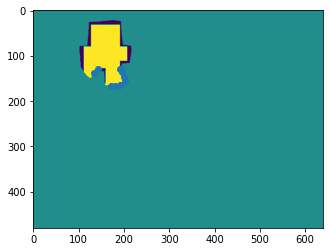

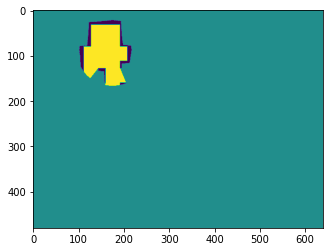

In [9]:
import numpy as np
import random

reward_func = PaperRewardFunction()
action_space = PolarActionSpace(30, 60)

robot = Robot(0, True, False, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)

frontiers = robot.frontier(robot.op_map, robot.map_size, robot.t)
frontiers = frontiers[np.random.choice(np.arange(0, frontiers.shape[0]), (10,)), :]
print(frontiers.shape)
print(frontiers)
plt.imshow(robot.op_map)
plt.scatter(frontiers[:, 0], frontiers[:, 1])
plt.show()
plt.imshow(robot.op_map)

In [10]:
import torch
import torch.nn as nn
import torchsummary
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

def build_conv_feature_extractor(conv_dims, act):
  #Create Conv2D + MaxPool layers
  conv_layers = [nn.Conv2d(*conv_dim) if len(conv_dim) == 3 else nn.MaxPool2d(conv_dim) for conv_dim in conv_dims]
  total_layers = []

  #Add ReLU activations after each conv layer
  for i, layer in enumerate(conv_layers):
    total_layers.append(layer)
    if type(layer) == nn.Conv2d:
      total_layers.append(act())
      total_layers.append(nn.BatchNorm2d(conv_dims[i][1]))
  return nn.Sequential(*total_layers)
  

def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape

class RNNActor(nn.Module):
  #TODO Determine if the action space allows negative numbers
  #Potentially replace tanh with sigmoid
  def __init__(self, conv_dims, lstm_hidden, train_length, input_size=(1, 1,84,84), act=nn.ReLU, final_act=nn.Sigmoid):
    super(RNNActor, self).__init__()

    self.conv_mod = build_conv_feature_extractor(conv_dims, act)
    
    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    print('LSTM Input Size', feature_size)

    #Construct LSTM
    self.lstm_hidden = lstm_hidden
    self.lstm_input = np.prod(list(feature_size)) + 2
    self.lstm = nn.LSTM(self.lstm_input, lstm_hidden)
    self.linear = nn.Linear(lstm_hidden, 2)
    self.train_length = train_length
    self.final_act = final_act()

  def forward(self, image, positions, lengths, hidden_state=None):
    batch_size = image.size()[1]
    seq_length = image.size()[0]
    conv = self.conv_mod(image.view((seq_length * batch_size, 1, 84, 84)))

    flat = conv.view(-1).view(seq_length, batch_size, self.lstm_input - 2)
    state = torch.cat((flat, positions), 2)
    packed = pack_padded_sequence(state, lengths, enforce_sorted=False)
    self.lstm.flatten_parameters()
    if hidden_state is not None:
      states, final_state = self.lstm(packed, hidden_state)
    else:
      states, final_state = self.lstm(packed)

    unpacked, end_lengths = pad_packed_sequence(states)
    final = self.linear(unpacked)
    return self.final_act(final), final_state, end_lengths

In [11]:
def build_dense_regression(linear_dims, act, final_act=None):
  linear_layers = [nn.Linear(*linear_dim)  for linear_dim in linear_dims]
  activations = [act() for layer in range(len(linear_layers) - 1)]
  #batch_norm = [nn.BatchNorm1d() for layer in range(len(linear_layers) - 1)]
  #batch_norm.append(nn.Identity())
  if final_act is not None:
    activations.append(final_act())
  else:
    activations.append(nn.Identity())
  return nn.Sequential(*[val for tup in zip(*[linear_layers, activations]) for val in tup]
)

class CNNCritic(nn.Module):
  def __init__(self, conv_dims, fc_dims, input_size=(1, 1,84,84), conv_act=nn.ReLU, fc_act=nn.ReLU):
    super(CNNCritic, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, conv_act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size)) + 4
    first_output = fc_dims[0][0]
    fc_dims.insert(0, (feature_size, first_output))

    self.fc = build_dense_regression(fc_dims, fc_act)
    self.fc_dims = feature_size

    


  def forward(self, map, positions, action):
    batch_size = map.size()[1]
    seq_length =  map.size()[0]
    conv = self.conv_mod(map.view((seq_length * batch_size, 1, 84, 84)))

    flat = conv.view(-1).view(seq_length, batch_size, self.fc_dims - 4)
    total_feats = torch.cat((flat, positions, action), 2)
    return self.fc(total_feats)

In [12]:
class ActorPolicy:
  def __init__(self, model):
    self.model = model

  def __call__(self, map, position):
    map = map.to(device='cuda').float().unsqueeze(0).unsqueeze(1)
    position = position.to(device='cuda').float().unsqueeze(0)

    result = self.model(map, position)

    return result.cpu().squeeze(0)

class CNNCriticNoSeq(nn.Module):
  def __init__(self, conv_dims, fc_dims, input_size=(1, 1,84,84), conv_act=nn.LeakyReLU, fc_act=nn.LeakyReLU):
    super(CNNCriticNoSeq, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, conv_act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size)) + 4
    first_output = fc_dims[0][0]
    fc_dims.insert(0, (feature_size, first_output))

    self.fc = nn.Linear(feature_size, 1)#build_dense_regression(fc_dims, fc_act)
    self.fc_dims = feature_size

    


  def forward(self, map, positions, action):
    conv = self.conv_mod(map)
    batch_size = map.size()[0]
    flat = conv.view(batch_size, self.fc_dims - 4)
#     print('flat', flat.size())
#     print('positions', positions.size())
    total_feats = torch.cat((flat, positions, action), 1)
    return self.fc(total_feats)



class FCActor(nn.Module):
  #TODO Determine if the action space allows negative numbers
  #Potentially replace tanh with sigmoid
  def __init__(self, conv_dims, linear_dims, input_size=(1, 1,84,84), act=nn.LeakyReLU, final_act=nn.Sigmoid):
    super(FCActor, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size)) + 2
    first_output = linear_dims[0][0]
    linear_dims.insert(0, (feature_size, first_output))

    self.fc = nn.Linear(feature_size, 2)#build_dense_regression(linear_dims, act, final_act)
    self.fc_dims = feature_size
    self.sig = nn.Sigmoid()

  def forward(self, map, positions):
    conv = self.conv_mod(map)

    flat = conv.view(map.size()[0], self.fc_dims - 2)
#     print('flat', flat.size())
#     print('positions', positions.size())
    total_feats = torch.cat((flat, positions), 1)
    return self.sig(self.fc(total_feats))

In [13]:
class CNNCriticNoSeqNoPosition(nn.Module):
  def __init__(self, conv_dims, fc_dims, input_size=(1, 1,84,84), conv_act=nn.LeakyReLU, fc_act=nn.LeakyReLU):
    super(CNNCriticNoSeq, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, conv_act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size)) + 2
    first_output = fc_dims[0][0]
    fc_dims.insert(0, (feature_size, first_output))

    self.fc = nn.Linear(feature_size, 1)#build_dense_regression(fc_dims, fc_act)
    self.fc_dims = feature_size

    


  def forward(self, map, positions, action):
    conv = self.conv_mod(map)
    batch_size = map.size()[0]
    flat = conv.view(batch_size, self.fc_dims - 2)
#     print('flat', flat.size())
#     print('positions', positions.size())
    total_feats = torch.cat((flat, positions, action), 1)
    return self.fc(total_feats)



class FCActorNoPosition(nn.Module):
  #TODO Determine if the action space allows negative numbers
  #Potentially replace tanh with sigmoid
  def __init__(self, conv_dims, linear_dims, input_size=(1, 1,84,84), act=nn.LeakyReLU, final_act=nn.Sigmoid):
    super(FCActor, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size))
    first_output = linear_dims[0][0]
    linear_dims.insert(0, (feature_size, first_output))

    self.fc = nn.Linear(feature_size, 2)#build_dense_regression(linear_dims, act, final_act)
    self.fc_dims = feature_size
    self.sig = nn.Sigmoid()

  def forward(self, map, positions):
    conv = self.conv_mod(map)

    flat = conv.view(map.size()[0], self.fc_dims)
#     print('flat', flat.size())
#     print('positions', positions.size())
    return self.sig(self.fc(flat))

In [14]:
""" Learn a policy using DDPG for the reach task"""
import numpy as np
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.nn import MSELoss
import random
from skimage.transform import resize
from io import BytesIO
import itertools
import lmdb
from itertools import zip_longest

import gym
import os

import matplotlib.pyplot as plt
import copy
import time
from google.colab import drive
drive.mount('/content/drive')

def save_models(actor, critic, actor_target, critic_target, i):
  torch.save(actor.state_dict(), '/content/drive/My Drive/models/actor_{}.pt'.format(i))
  torch.save(critic.state_dict(), '/content/drive/My Drive/models/critic_{}.pt'.format(i))
  torch.save(critic_target.state_dict(), '/content/drive/My Drive/models/critic_target_{}.pt'.format(i))
  torch.save(actor_target.state_dict(), '/content/drive/My Drive/models/actor_target_{}.pt'.format(i))
  

# TODO: A function to soft update target networks
def weighSync(target_model, source_model, tau=0.001):
  for (target, src) in zip(target_model.parameters(), source_model.parameters()):
    target.data = (1-tau) * target.data + tau * src.data 

def grouper(iterable, n, fillvalue=None):
  '''Collect data into fixed-length chunks or blocks'''
  # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
  args = [iter(iterable)] * n
  return zip_longest(*args, fillvalue=fillvalue)

# TODO: Write the ReplayBuffer
class Replay():
    def __init__(self, buffer_size, init_sequences, max_episode_length, sequence_length, action_dim, env, test_env, env_width, env_height):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        try:
          os.remove('db.lmdb')
        except OSError:
          pass
        self.db = lmdb.open('db.lmdb', map_size=30e9)
        self.buffer = [{}] * buffer_size
        self.noise = MultivariateNormal(torch.zeros(2), torch.diag(torch.tensor([0.1, 0.1])))
        self.sequence_length = sequence_length
        self.max_episode_length = max_episode_length
        self.env = env
        self.test_env = test_env
        state = self.env.reset()
        self.buffer_length = buffer_size
        self.env_width = env_width
        self.env_height = env_height
        self.buffer_idx = 0
        self.total_steps = 0
        last_state = env.reset()
        init_policy = lambda map, pos, env: [torch.from_numpy(np.random.uniform(0, 1, (2,)))]
        self.full_buffer = False
        self.current_pointer = 0

        map, position = self.env.reset()
        map = np.pad(map, ((map.shape[0], map.shape[1]), (map.shape[0], map.shape[1])), constant_values=127)
        #idx = (int(map.shape[0] / 2), int(position[1] - map.shape[1] / 2))
        #map = np.roll(map, idx, [0, 1])
        map = resize(map, (168, 168))
        map = map / 255
        position = position.astype(np.float64)
        position[0] = position[0] / 480
        position[1] = position[1] / 640
        action = {'map':torch.from_numpy(map).float(), 'position':torch.from_numpy(position).float()}
        
        while self.buffer_idx < init_sequences:
          action, terminal = self.generate_step(init_policy, action, False)
#           print('action', action)
#           print('terminal', terminal)
          if terminal:
            map, position = self.env.reset()

            map = resize(map, (168, 168))
            map = map / 255
            position = position.astype(np.float64)
            position[0] = position[0] / 480
            position[1] = position[1] / 640
            action = {'map':torch.from_numpy(map).float(), 'position':torch.from_numpy(position).float()}


    def generate_step(self, policy, last_transition, add_noise=True, store=True, test=False):
      if test:
        env = self.test_env
      else:
        env = self.env
      episode = []
      last_map = last_transition['map']
      last_position = last_transition['position']

      terminal = False

      total_reward = 0

      actions = policy(last_map, last_position, env)
      last_act = None
      if len(actions) == 0:
        terminal = True
      for action in actions:
        if add_noise:
          sampled = self.noise.sample()
          #print('adding noise', sampled)
          action = action.cpu() + sampled
        else:
          action = action.cpu()

        action_np = action.detach().numpy().flatten()
        if action_np[0] < 0:
          action_np[0] = abs(action_np[0])
        elif action_np[0] > 1:
          action_np[0] = action_np[0] - 1

        if action_np[1] < 0:
          action_np[1] = abs(action_np[1])
        elif action_np[1] > 1:
          action_np[1] = action_np[1] - 1

    

        (map, loc), reward, terminal, complete, new_loc, collision, all_map = env.step(action_np)
        #map = np.pad(map, ((map.shape[0], map.shape[1]), (map.shape[0], map.shape[1])), constant_values=127)
        #idx = (int(map.shape[0] / 2 - loc[0]), int(map.shape[1] / 2 - loc[1]))
        #map = np.roll(map, idx, axis=[0, 1])

        #print('shifted', idx)
        #plt.imshow(map)
        #plt.show()
        map = resize(map, (168, 168))
        map = (map / 255)
        loc = loc.astype(np.float64)
        loc[0] = loc[0] / 480.0
        loc[1] = loc[1] / 640.0

        map_tensor = torch.from_numpy(map).float()
        position_tensor = torch.from_numpy(loc).float()
        reward_tensor = torch.tensor(reward).float()
        action = {'last_map':last_map, 'last_position':last_position, 'map': map_tensor.detach(), 'position': position_tensor.detach(), 'reward': reward_tensor.unsqueeze(0).detach(), 'action': action.detach()}
        last_act = action
        total_reward += reward

        if store:
          self.write_one_transition(action, self.buffer_idx)
          self.buffer_idx = (self.buffer_idx + 1) % len(self.buffer)
          if self.buffer_idx == 0:
            self.full_buffer = True

      return last_act, terminal

    def write_one_transition(self, trans, idx):
      actions = trans['action']
      rewards = trans['reward']
      maps = trans['map']
      positions = trans['position']

      last_map = trans['last_map']
      last_position = trans['last_position']

#       print('actions', actions.size())
#       print('rewards', rewards.size())
#       print('maps', maps.size())
#       print('positions', positions.size())
#       print('last_map', last_map.size())
#       print('last_position', last_position.size())

      total_tensor = torch.cat((actions, rewards, positions, last_position), 0)
      total_maps = torch.cat((maps, last_map), 0)
      with self.db.begin(write=True) as txn:
        total_bytes = BytesIO()
        maps_bytes = BytesIO()

        torch.save(total_tensor, total_bytes)
        torch.save(total_maps, maps_bytes)
        
        txn.put('{}_total'.format(idx).encode(), total_bytes.getvalue())
        txn.put('{}_maps'.format(idx).encode(), maps_bytes.getvalue())

    def sample_transitions(self, N):
      """
      A function to sample N points from the buffer
      param: N : Number of samples to obtain from the buffer
      """
      if self.full_buffer:
        samples = np.random.permutation(range(self.buffer_length))
      else:
        samples = np.random.permutation(range(self.buffer_idx))

      samples = samples[:N]
      return self.read_transitions(samples)

    def read_transitions(self, transitions):
      maps = []
      positions = []
      rewards = []
      actions = []
      last_maps = []
      last_positions = []

      for seq in transitions:
        with self.db.begin() as txn:
          total_data = BytesIO(txn.get('{}_total'.format(seq).encode()))
          map_data = BytesIO(txn.get('{}_maps'.format(seq).encode()))      

          total_tensor = torch.load(total_data)
          map_tensor = torch.load(map_data)
#           print('map tensor', map_tensor.size())
          maps.append(map_tensor[:168, :].unsqueeze(0))
          last_maps.append(map_tensor[168:, :].unsqueeze(0))
          positions.append(total_tensor[3:5].unsqueeze(0))
          actions.append(total_tensor[:2].unsqueeze(0))
          rewards.append(total_tensor[2].unsqueeze(0))
          last_positions.append(total_tensor[5:].unsqueeze(0))

      map_pad = torch.cat(maps, 0).to(device='cuda').float()
      pos_pad = torch.cat(positions, 0).to(device='cuda').float()
      reward_pad = torch.cat(rewards, 0).to(device='cuda').float()
      action_pad = torch.cat(actions, 0).to(device='cuda').float()
      last_positions = torch.cat(last_positions, 0).to(device='cuda').float()
      last_maps = torch.cat(last_maps, 0).to(device='cuda').float()

      return map_pad, pos_pad, reward_pad, action_pad, last_positions, last_maps

    def generate_episode(self, policy, add_noise=True, store=True, test=False, plot=False, do_print=False):
      episode = []
      self.env.plot = plot
      map, position = self.env.reset()
      position = position.astype(np.float64)
      map = resize(map, (168, 168))
      map = ((map - 127) / 255) * 2

      position[0] = position[0]/ 640.0
      position[1] = position[1] / 480.0
      last_map = torch.from_numpy(map).float()
      last_position = torch.from_numpy(position).float()
      terminal = False

      total_reward = 0
      last_state = None
      for i in range(self.max_episode_length):
        if last_state is None:
          action, last_state, lengths = policy(last_map.unsqueeze(0).unsqueeze(0).to(device='cuda'), last_position.unsqueeze(0).unsqueeze(0).to(device='cuda'), [1])
        else:
          action, last_state, lengths = policy(last_map.unsqueeze(0).unsqueeze(0).to(device='cuda'), last_position.unsqueeze(0).unsqueeze(0).to(device='cuda'), [1], last_state)
      
        if add_noise:
          sampled = self.noise.sample()
          #print('adding noise', sampled)
          action = action.cpu().squeeze(0).squeeze(1) + sampled
        else:
          action = action.cpu().squeeze(0).squeeze(1)

        action_np = action.detach().numpy().flatten()
        if action_np[0] < 0:
          action_np[0] = abs(action_np[0])
        elif action_np[0] > 1:
          action_np[0] = action_np[0] - 1

        if action_np[1] < 0:
          action_np[1] = abs(action_np[1])
        elif action_np[1] > 1:
          action_np[1] = action_np[1] - 1


        if do_print:
          print('action', action_np)

    

        (map, loc), reward, terminal, complete, new_loc, collision, all_map = self.env.step(action_np)
        map = resize(map, (168, 168))
        map = ((map - 127) / 255)
        loc = loc.astype(np.float64)
        loc[0] = loc[0] / 640.0
        loc[1] = loc[1] / 480.0

        map_tensor = torch.from_numpy(map).float()
        position_tensor = torch.from_numpy(loc).float()
        reward_tensor = torch.tensor(reward).float()
        episode.append({'map': map_tensor.detach(), 'position': position_tensor.detach(), 'reward': reward_tensor.detach(), 'action': action.detach()})
        last_map = map_tensor.to(device='cuda')
        last_position = position_tensor.to(device='cuda')
        total_reward += reward
        if terminal:
          break

      if store:
        sequences = self.episode_to_sequences(episode)
        for sequence in sequences:
          self.write_sequence(sequence, self.buffer_idx)
          self.buffer_idx = (self.buffer_idx + 1) % len(self.buffer)
          if self.buffer_idx == 0:
            self.full_buffer = True

      self.env.plot = False
      return total_reward

    def write_sequence(self, sequence, idx):
      actions = sequence['actions']
      rewards = sequence['rewards']
      maps = sequence['maps']
      positions = sequence['positions']

      len = sequence['len']
      total_tensor = torch.cat((actions, rewards.unsqueeze(1).unsqueeze(1), positions.unsqueeze(1)), 2)
      with self.db.begin(write=True) as txn:
        total_bytes = BytesIO()
        maps_bytes = BytesIO()

        torch.save(total_tensor, total_bytes)
        torch.save(maps, maps_bytes)
        
        txn.put('{}_total'.format(idx).encode(), total_bytes.getvalue())
        txn.put('{}_maps'.format(idx).encode(), maps_bytes.getvalue())
        txn.put('{}_len'.format(idx).encode(), str(len).encode())

    def read_sequences(self, sequences):
        map_sequences = []
        position_sequences = []
        reward_sequences = []
        action_sequences = []
        seq_lens = []

        for seq in sequences:
            with self.db.begin() as txn:
                total_data = BytesIO(txn.get('{}_total'.format(seq).encode()))
                map_data = BytesIO(txn.get('{}_maps'.format(seq).encode()))
                length = txn.get('{}_len'.format(seq).encode())


                total_tensor = torch.load(total_data)
                map_tensor = torch.load(map_data)
                map_sequences.append(map_tensor)
                position_sequences.append(total_tensor[:, :, 3:])
                action_sequences.append(total_tensor[:, :, :2])
                reward_sequences.append(total_tensor[:, :, 2])
                seq_lens.append(int(length))

        map_pad = pad_sequence(map_sequences).to(device='cuda').float()
        pos_pad = pad_sequence(position_sequences).to(device='cuda').float()
        reward_pad = pad_sequence(reward_sequences).to(device='cuda').float()
        action_pad = pad_sequence(action_sequences).to(device='cuda').float()
        seqs = seq_lens



        return map_pad, pos_pad, reward_pad, action_pad, seqs
    
    def episode_to_sequences(self, episode):
      sequences = []
      last_idx = 0
      for i in np.arange(self.sequence_length, len(episode), self.sequence_length):
        window = episode[last_idx:i]
        map_tensor = torch.cat([torch.unsqueeze(data['map'], 0) for data in window], 0)
        position_tensor = torch.cat([torch.unsqueeze(data['position'], 0) for data in window], 0)
        reward_tensor = torch.cat([torch.unsqueeze(data['reward'], 0) for data in window], 0)
        action_tensor = torch.cat([torch.unsqueeze(data['action'], 0) for data in window], 0)
        sequences.append({'maps':map_tensor, 'positions': position_tensor, 'rewards': reward_tensor, 'actions':action_tensor, 'len':len(window)})
        last_idx = i

      window = episode[last_idx:]
      map_tensor = torch.cat([torch.unsqueeze(data['map'], 0) for data in window], 0)
      position_tensor = torch.cat([torch.unsqueeze(data['position'], 0) for data in window], 0)
      reward_tensor = torch.cat([torch.unsqueeze(data['reward'], 0) for data in window], 0)
      action_tensor = torch.cat([torch.unsqueeze(data['action'], 0) for data in window], 0)
      sequences.append({'maps':map_tensor, 'positions': position_tensor, 'rewards': reward_tensor, 'actions':action_tensor, 'len':len(window)})
      return sequences
    

    #TODO: Complete the function
    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        param: N : Number of samples to obtain from the buffer
        """
        if self.full_buffer:
          samples = np.random.permutation(range(self.buffer_length))
        else:
          samples = np.random.permutation(range(self.buffer_idx))

        samples = samples[:N]
        return self.read_sequences(samples)

    def batchify(self, samples):
      
      map_sequences = []
      position_sequences = []
      reward_sequences = []
      action_sequences = []
      seq_lens = []

      for sequence in samples:

        map_sequences.append(sequence['maps'])
        position_sequences.append(sequence['positions'])
        reward_sequences.append(sequence['rewards'])
        action_sequences.append(sequence['actions'])
        seq_lens.append(sequence['len'])

      map_pad = pad_sequence(map_sequences).to(device='cuda').float()
      pos_pad = pad_sequence(position_sequences).to(device='cuda').float()
      reward_pad = pad_sequence(reward_sequences).to(device='cuda').float()
      action_pad = pad_sequence(action_sequences).to(device='cuda').float()
      seqs = seq_lens

      return map_pad, pos_pad, reward_pad, action_pad, seqs

      


Mounted at /content/drive


In [15]:
# TODO: Implement a DDPG class
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()


class DDPG():
    def __init__(
            self,
            env,
            conv_dims,
            state_dim,
            linear_dims,
            actor_linear_dims,
            sequence_length,
            replay,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
            seed=1000
    ):
        """
        param: env: An gym environment
        param: action_dim: Size of action space
        param: state_dim: Size of state space
        param: critic_lr: Learning rate of the critic
        param: actor_lr: Learning rate of the actor
        param: gamma: The discount factor
        param: batch_size: The batch size for training
        """
        np.random.seed(seed)
        torch.manual_seed(seed)
        action_dim = 2
        self.gamma = gamma
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.env = env
        self.state_dim = state_dim
        self.actor = FCActor(conv_dims, actor_linear_dims).float().to(device='cuda')
        print(self.actor)

        # TODO: Create a actor and actor_target
        self.actor_target = copy.deepcopy(self.actor)

        # TODO: Make sure that both networks have the same initial weights

        # TODO: Create a critic and critic_target object
        self.critic = CNNCriticNoSeq(conv_dims, linear_dims).float().to(device='cuda')
        print(self.critic)
        self.critic_target = copy.deepcopy(self.critic)
        # TODO: Make sure that both networks have the same initial weights

        # TODO: Define the optimizer for the actor
        self.optimizer_actor = optim.Adam(self.actor.parameters(), actor_lr)
        # TODO: Define the optimizer for the critic
        self.optimizer_critic = optim.Adam(self.critic.parameters(), critic_lr)

        # TODO: define a replay buffer
        #buffer_size, init_episodes, max_episode_length, state_dim, action_dim, env, env_width, env_height
        self.replay = replay

    # TODO: Complete the function
    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic_target, self.critic)

    # TODO: Complete the function
    def update_network(self, y_i, maps, positions, actions, last_maps, last_positions, i):
        """
        A function to update the function just once
        """

        qs = self.critic(last_maps, last_positions, actions)
        #print('critic loss sizes')
        #print(y_i.size())
        #print(qs.size())
        #should be (seq_len, batch, 1)
        #should be (seq_len, batch, 1)
        criterion = nn.MSELoss()
        critic_loss = criterion(qs, y_i)
        #print('critic loss', critic_loss)
        critic_loss.backward()
        if i % 500 == 0:
          print("CRITIC")
          plot_grad_flow(self.critic.named_parameters())

        self.optimizer_critic.step()

        #last_positions = (last_positions - last_positions.mean(0)) / last_positions.std(0)

        new_act = self.actor(last_maps, last_positions)
        new_qs = self.critic(last_maps, last_positions, new_act)
        actor_loss = new_qs.mean()
        #print('actor_loss', actor_loss)
        (-actor_loss).backward()
        
        if i % 500 == 0:
          print("ACTOR")
          plot_grad_flow(self.actor.named_parameters())
        self.optimizer_actor.step()

  
    # TODO: Complete the function
    def train(self, num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps:The number of steps to train the policy for
        """
        self.critic_criterion = MSELoss()
        num_episodes = 0
        i = 0
        total_reward = 0
        total_steps = 0
        episode_reward = 0
        steps_list = []
        rewards = []
        start = time.time()
        total_target_time = 0
        total_backprop_time = 0
        total_gen_episode_time = 0
        total_test_time = 0
        total_dataload_time = 0

        
        map, position = self.replay.env.reset()
        map = resize(map, (168, 168))
        map = map / 255
        position = position.astype(np.float64)
        position[0] = position[0] / 480
        position[1] = position[1] / 640
        action = {'map':torch.from_numpy(map).float(), 'position':torch.from_numpy(position).float()}
        
        while i < num_steps:
            self.optimizer_critic.zero_grad()
            self.optimizer_actor.zero_grad()
            gen_start = time.time()
            action, terminal = self.replay.generate_step(ActorPolicy(self.actor), action)
            total_gen_episode_time += time.time() - gen_start
            total_reward += action['reward'].item()
            if i%100==0:
                print('step {}'.format(i))
                save_models(self.actor, self.critic, self.actor_target, self.critic_target, i)
                #print(total_reward)
                #print(action)
            if terminal:
                total_reward = 0
                map, position = self.env.reset()
                map = resize(map, (168, 168))
                map = map / 255
                position = position.astype(np.float64)
                position[0] = position[0] / 480
                position[1] = position[1] / 640
                action = {'map':torch.from_numpy(map).float(), 'position':torch.from_numpy(position).float()}


            #maps.size() -> (seq_len, batch_size, 1, 224, 224)
            #positons.size() -> (seq_len, batch_size, 2)
            #rewards.size() -> (seq_len, batch_size, 1)
            # actions -> (seq_len, batch_size, 2)
            dataload_time = time.time()
            maps, positions, rewards, actions, last_positions, last_maps = self.replay.sample_transitions(self.batch_size)
            maps = maps.unsqueeze(1)
            last_maps = last_maps.unsqueeze(1)

            total_dataload_time += time.time() - dataload_time

            target_start = time.time()
            with torch.no_grad():
                target_action = self.actor_target(last_maps, last_positions)
                #print('target action', target_action.size())
                #Should be (seq_len, batch_size, 2)
                #Should be (seq_len, batch_size, 1)
                crit = self.critic_target(maps, positions, target_action)
                #print('rewards', rewards.size())
                #print('crit', crit.size())
                ys = rewards.unsqueeze(1) + self.gamma * crit

            total_target_time += time.time() - target_start
            update_start = time.time()
            self.update_network(ys, maps, positions, actions, last_maps, last_positions, i)

            self.update_target_networks()
            total_backprop_time += time.time() - update_start
            i += 1
            if i % 500 == 0:
             print('step {}'.format(i))
             print('avg iter time {}'.format((time.time() - start) / i))

             reward = 0
             start_test = time.time()
             for j in range(5):
               test_map, test_position = self.replay.test_env.reset()
               test_map = resize(test_map, (168, 168))
               test_map = test_map / 255
               test_position = test_position.astype(np.float64)
               test_position[0] = test_position[0] / 480
               test_position[1] = test_position[1] / 640
               test_action = {'map':torch.from_numpy(test_map).float(), 'position':torch.from_numpy(test_position).float()}
               x = 0
               total_reward = 0
               while x < 300:
                 test_action, test_terminal = self.replay.generate_step(ActorPolicy(self.actor), test_action, False, False, True)
                 print('action', test_action)
                 print('terminal', test_terminal)
                 total_reward += test_action['reward'].item()
                 if test_terminal:
                   test_map, test_position = self.replay.test_env.reset()

                   test_map = resize(test_map, (168, 168))
                   test_map = test_map / 255
                   test_position = test_position.astype(np.float64)
                   test_position[0] = test_position[0] / 480
                   test_position[1] = test_position[1] / 640
                   test_action = {'map':torch.from_numpy(test_map).float(), 'position':torch.from_numpy(test_position).float()}
                   break
                 x += 1

#             print('test reward', total_reward)
#             total_test_time = time.time() - start
#             print('avg test time', total_test_time / 5)
#             print('avg target time', total_target_time / i)
#             print('avg backprop time', total_backprop_time / i)
#             print('avg data load time', total_dataload_time / i)
#             print('avg gen episode time', total_gen_episode_time / i)
            #  test_done = False
            #  episode_reward = 0
            #  the_steps = 0
            #  s = test_env.reset()
            #  while not test_done:
            #    total_steps += 1
            #    the_steps += 1
            #    action = self.actor(torch.from_numpy(s).float().to(device='cuda')).detach().squeeze().cpu().numpy()
            #    n_state, r, test_done, _ = test_env.step(action)
            #    s = n_state
            #    episode_reward += r

            #  rewards.append(episode_reward)
            #  steps_list.append(the_steps)
            #  print('Episode reward')
            #  print(episode_reward)

        return rewards, steps_list

In [36]:
import random
from copy import deepcopy
class GuidedExplorationPolicy:

  def __init__(self, prob_guided, model, action_space, noise_var):
    self.prob_guided = prob_guided
    self.model = model
    self.action_space = action_space
    #self.noise = torch.MultivariateGaussian(torch.zeros(2), torch.diag([noise_var,noise_var]))

  def __call__(self, map, location, env):
    p = random.random()
    actions = []
    if p < self.prob_guided:
      rescue_map, rescue_path = env.rescuer()
      location = location.cpu().numpy()
      location[0] *= 640
      location[1] *= 480
      last_point = location
      point = 0
      count  = 0
      while point < rescue_path.shape[1]:
        count += 1
        next_point = rescue_path[[1, 0], point].astype(np.float64)
        dist = np.linalg.norm(next_point - location)
        _, coll = env.collision_check(location.astype(np.int64), next_point.astype(np.int64), env.map_size, env.global_map) 

        if coll or dist > self.action_space.max_distance:
          diff = (last_point - location).astype(np.float64)
          angle = np.arctan2(diff[0], diff[1])
          dist = np.linalg.norm(diff)
          if angle < 0:
            angle += 2 * np.pi
          angle = angle / (2 * np.pi)
          dist = (dist - self.action_space.min_travel) / (self.action_space.max_distance - self.action_space.min_travel)
          location = next_point
          last_point = next_point
          print('appending', angle, dist)
          actions.append(torch.from_numpy(np.array([angle, dist])).to(device='cuda').float())
        else:
          point += 1
          last_point = next_point
      
      
      _, coll = env.collision_check(location.astype(np.int64), last_point.astype(np.int64), env.map_size, env.global_map)
      dist = np.linalg.norm(last_point - location)
      #if coll or dist > self.action_space.max_distance:
      diff = (last_point - location).astype(np.float64)
      angle = np.arctan2(diff[0], diff[1])
      if angle < 0:
        angle += 2 * np.pi
      dist = np.linalg.norm(diff)
      print('appending last', angle, dist)
      angle = angle / (2 * np.pi)
      dist = (dist - self.action_space.min_travel) / (self.action_space.max_distance - self.action_space.min_travel)
      actions.append(torch.from_numpy(np.array([angle, dist])).to(device='cuda').float())
    else:
      map = map.to(device='cuda').float().unsqueeze(0).unsqueeze(1)
      position = position.to(device='cuda').float().unsqueeze(0)

      result = self.model(map, position)

    return actions

In [37]:
class ClippedLinearFrontierDistanceReward:
    def __init__(self, reward_scale):
        self.reward_scale = reward_scale
        self.paper_reward = PaperRewardFunction()

    def frontiers(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]

        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def astar_path(self, weights, start, goal, allow_diagonal=True):
        temp_start = [start[1], start[0]]
        temp_goal = [goal[1], goal[0]]
        temp_weight = (weights < 150) * 254 + 1
        # For the heuristic to be valid, each move must cost at least 1.
        if temp_weight.min(axis=None) < 1.:
            raise ValueError("Minimum cost to move must be 1, but got %f" % (
                temp_weight.min(axis=None)))
        # Ensure start is within bounds.
        if (temp_start[0] < 0 or temp_start[0] >= temp_weight.shape[0] or
                temp_start[1] < 0 or temp_start[1] >= temp_weight.shape[1]):
            raise ValueError("Start lies outside grid.")
        # Ensure goal is within bounds.
        if (temp_goal[0] < 0 or temp_goal[0] >= temp_weight.shape[0] or
                temp_goal[1] < 0 or temp_goal[1] >= temp_weight.shape[1]):
            raise ValueError("Goal of lies outside grid.")

        height, width = temp_weight.shape
        start_idx = np.ravel_multi_index(temp_start, (height, width))
        goal_idx = np.ravel_multi_index(temp_goal, (height, width))

        path = astar(
            temp_weight.flatten(), height, width, start_idx, goal_idx, allow_diagonal,
        )
        return path

    def get_reward(self, robot_pos, old_op_map, op_map, coll_index):
        paper_reward = self.paper_reward.get_reward(robot_pos, old_op_map,
                                                    op_map, coll_index)
        
        #If there was a collision return the collision reward
        if coll_index:
            print('collided??')
            return paper_reward

        frontiers = np.array(
            self.frontiers(op_map, op_map.shape, self.map_points(op_map)))

        for frontier in range(frontiers.shape[0]):
          frontier = frontiers[frontier, :]
          path = self.astar_path(op_map, robot_pos, frontier)
          dist = 0
          last_point = robot_pos
          for point in range(1, path.shape[1]):
            point = path[:, point]
            dist += np.linalg.norm(point - last_point)
            paper_reward += np.clip(-self.reward_scale * dist, 0, 1)
        
        return paper_reward

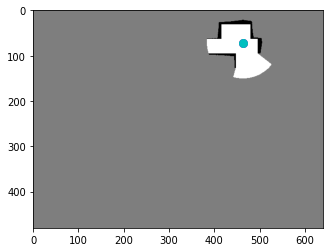

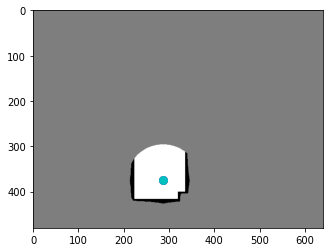

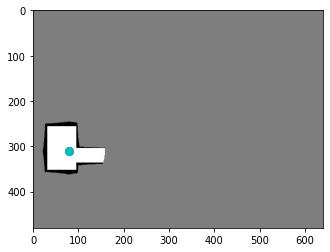

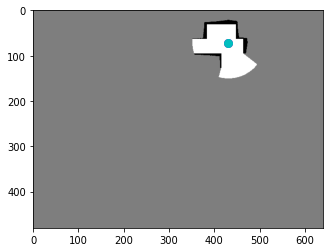

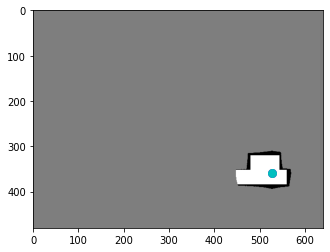

collided??


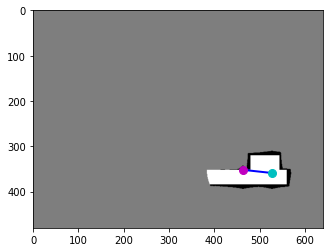

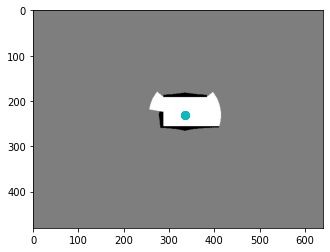

collided??


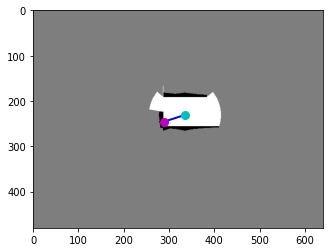

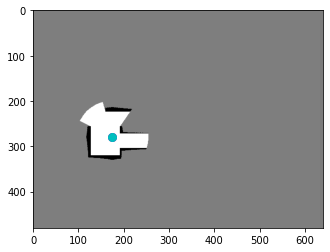

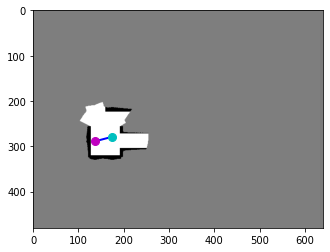

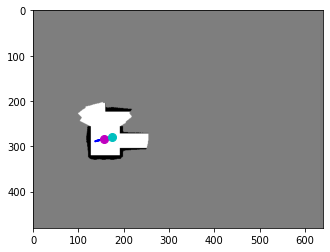

collided??


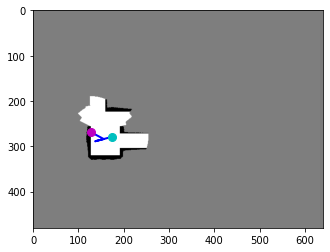

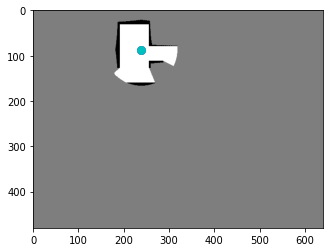

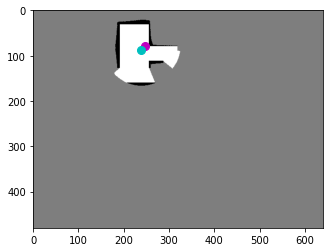

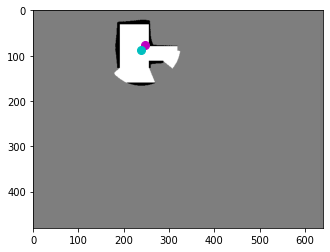

collided??


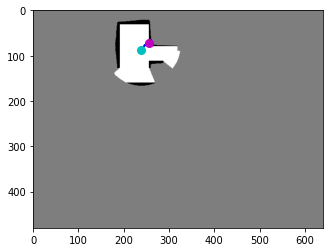

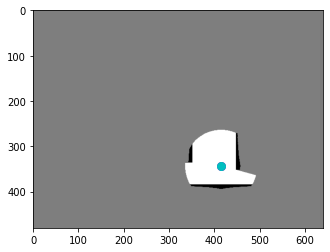

collided??


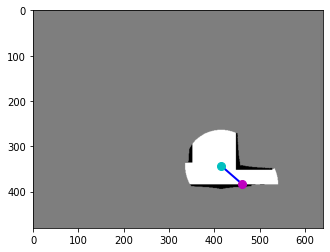

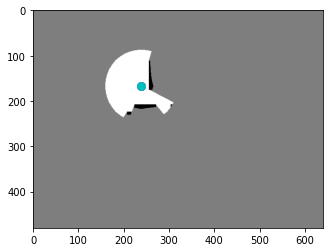

collided??


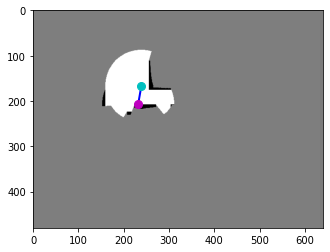

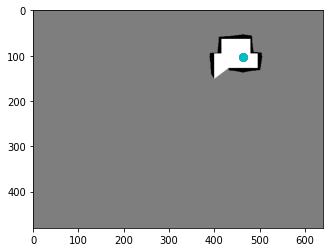

In [38]:
reward_func = ClippedLinearFrontierDistanceReward(1 / 320)
action_space = PolarActionSpace(0, 120)


test2 = Robot(0, True, True, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)
test1 = Robot(0, True, True, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)

test_replay = Replay(100, 10, 300, 4, 2, test1, test2, 640, 480)


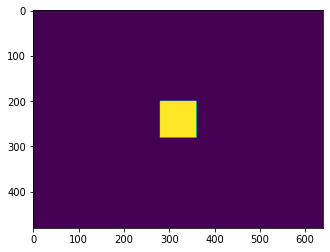

In [39]:
test = np.zeros((480, 640))
test[0:81, 0:81] = 255
#shift = 
padded = np.pad(test, ((480, 640), (480, 640)))
shifted = np.roll(test, (240-40, 320-40), [0,1])
plt.imshow(shifted)

tensor([[0.1353, 0.7222]], device='cuda:0')


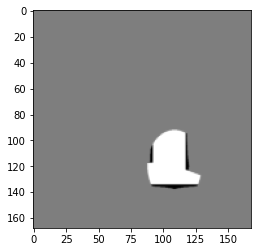

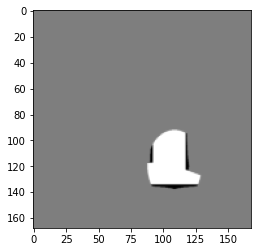

In [40]:
map, position, reward, action, last_position, last_map = test_replay.sample_transitions(1)
img1 = last_map.cpu().squeeze(0).numpy()
img2 = map.cpu().squeeze(0).numpy()
print(action)
plt.imshow(img1, cmap='gray')
plt.show()
plt.clf()
plt.imshow(img2, cmap='gray')
plt.show()

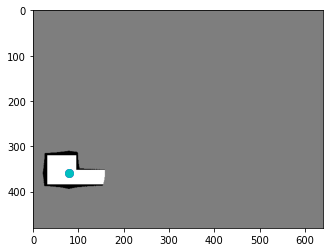

appending 0.0 0.0
appending last 1.2610933822524404 78.74642849044012


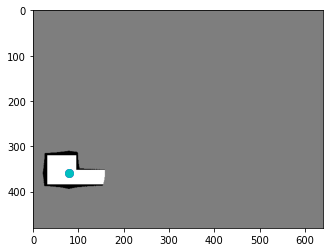

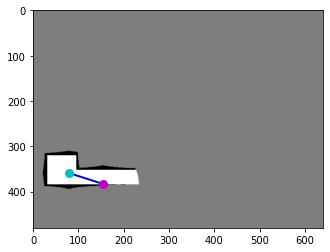

test action {'last_map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'last_position': tensor([105.3333, 269.2500]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.3208, 0.5984]), 'reward': tensor([0.3379]), 'action': tensor([0.2007, 0.6562])}
terminal False
reward

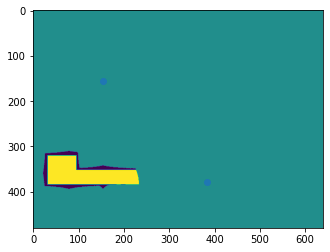

showing frontier
appending 0.0 0.0
appending last 1.5707963267948966 30.0


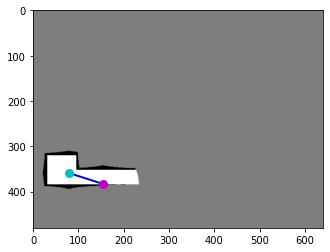

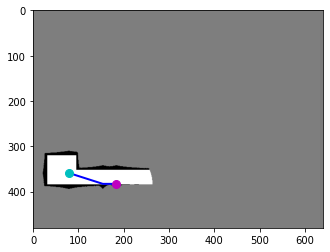

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([0.2194, 0.4207]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.3833, 0.5984]), 'reward': tensor([0.1371]), 'action': tensor([0.2500, 0.2500])}
terminal False
reward ten

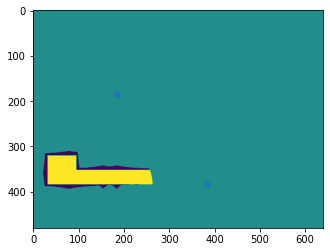

showing frontier
appending 0.0 0.0
appending last 1.5707963267948966 30.0


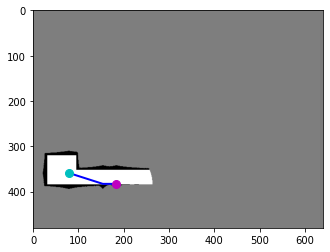

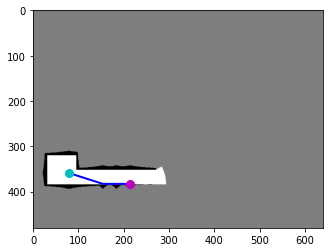

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([0.0005, 0.0007]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.4458, 0.5984]), 'reward': tensor([0.1457]), 'action': tensor([0.2500, 0.2500])}
terminal False
reward ten

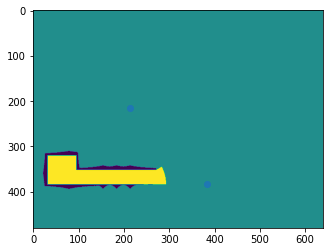

showing frontier
appending 0.0 0.0
appending last 1.5707963267948966 30.0


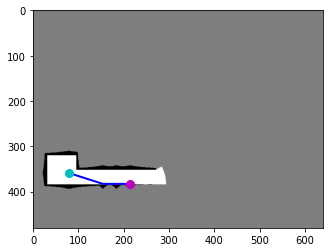

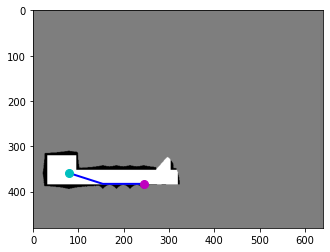

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([9.5245e-07, 1.0271e-06]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5083, 0.5984]), 'reward': tensor([0.1973]), 'action': tensor([0.2500, 0.2500])}
terminal False
re

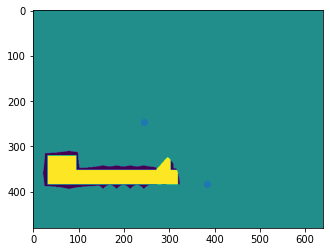

showing frontier
appending 0.0 0.0
appending last 2.4206213296178984 43.93176527297759


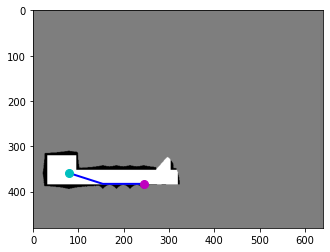

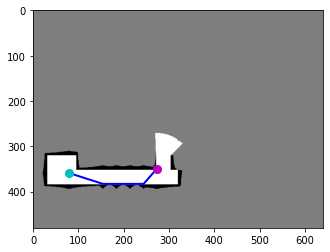

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([1.9843e-09, 1.6049e-09]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5688, 0.5469]), 'reward': tensor([0.3776]), 'action': tensor([0.3853, 0.3661])}
terminal False
re

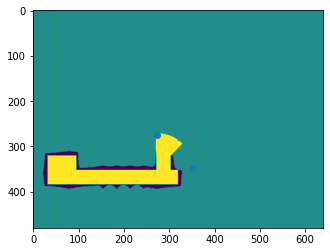

showing frontier
appending 0.0 0.0
appending 0.5040800019844051 0.325106820052186
appending last 3.1672280621114703 39.01281840626232


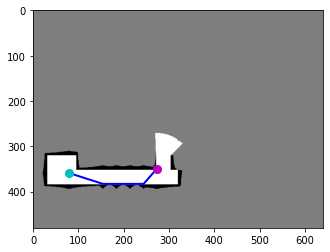

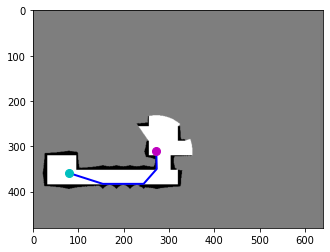

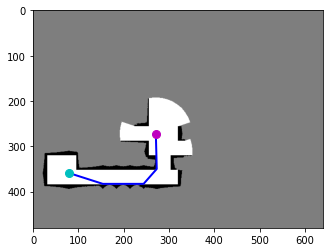

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([4.1339e-12, 2.5076e-12]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5646, 0.4250]), 'reward': tensor([0.7173]), 'action': tensor([0.5041, 0.3251])}
terminal False
re

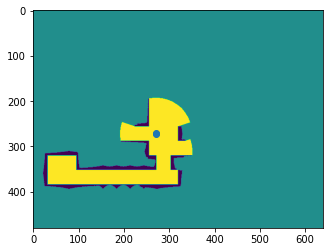

showing frontier
appending 0.0 0.0
appending last 4.611467195717395 79.40403012442127


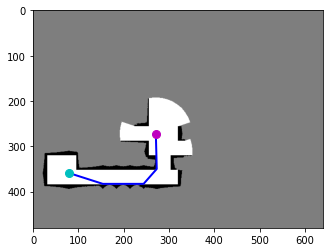

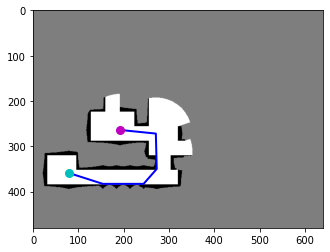

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([8.6123e-15, 3.9181e-15]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.4000, 0.4125]), 'reward': tensor([0.8794]), 'action': tensor([0.7339, 0.6617])}
terminal False
re

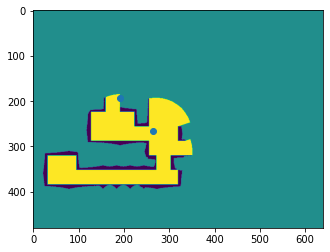

showing frontier
appending 0.0 0.0
appending last 3.5598169831690223 78.79086241436883


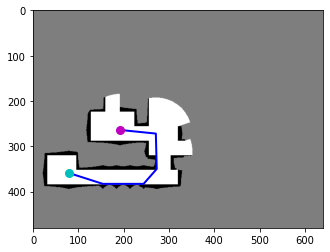

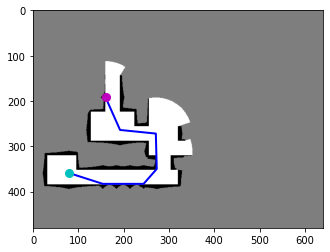

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([1.7942e-17, 6.1220e-18]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.3333, 0.3000]), 'reward': tensor([0.3524]), 'action': tensor([0.5666, 0.6566])}
terminal False
re

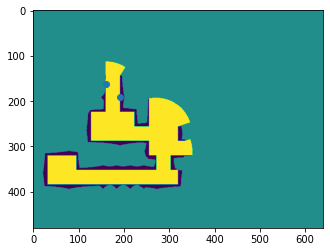

showing frontier
appending 0.0 0.0
appending last 3.141592653589793 79.0


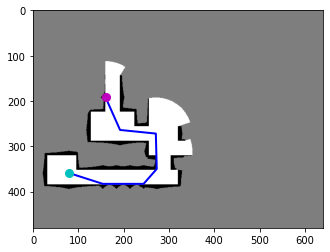

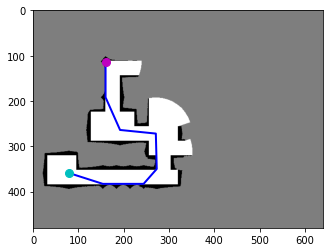

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([3.7380e-20, 9.5657e-21]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.3333, 0.1766]), 'reward': tensor([0.2026]), 'action': tensor([0.5000, 0.6583])}
terminal False
re

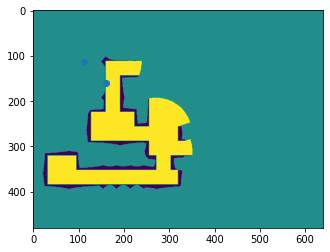

showing frontier
appending 0.0 0.0
appending last 1.590793660768047 50.00999900019995


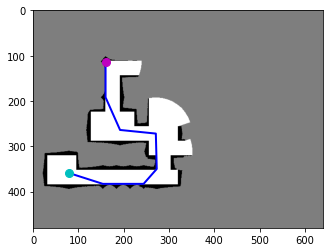

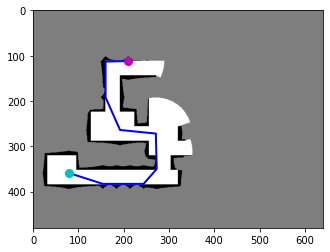

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([7.7874e-23, 1.4946e-23]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.4375, 0.1750]), 'reward': tensor([0.2324]), 'action': tensor([0.2532, 0.4167])}
terminal False
re

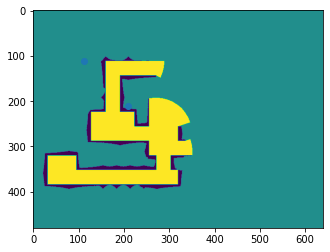

showing frontier
appending 0.0 0.0
appending last 1.5707963267948966 30.0


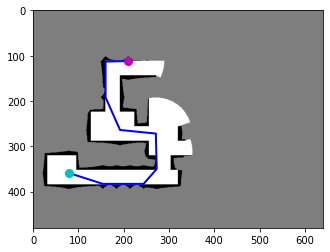

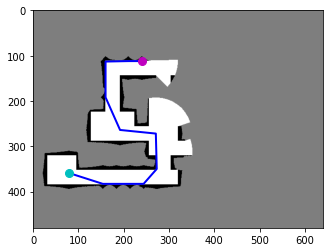

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([1.6224e-25, 2.3354e-26]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5000, 0.1750]), 'reward': tensor([0.2114]), 'action': tensor([0.2500, 0.2500])}
terminal False
re

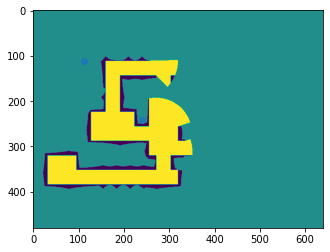

showing frontier
appending 0.0 0.0
appending last 1.5707963267948966 16.0


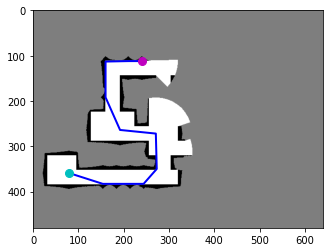

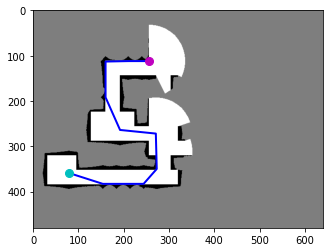

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([3.3800e-28, 3.6490e-29]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5333, 0.1750]), 'reward': tensor([0.8309]), 'action': tensor([0.2500, 0.1333])}
terminal False
re

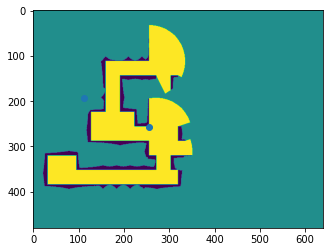

showing frontier
appending 0.0 0.0
appending last 3.141592653589793 79.0


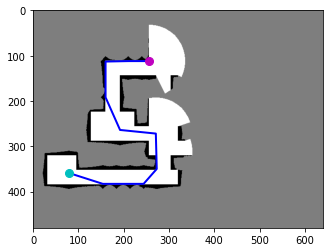

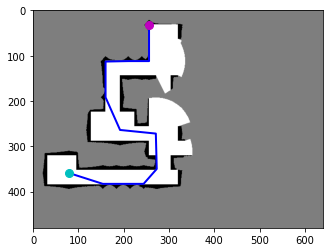

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([7.0416e-31, 5.7016e-32]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5333, 0.0516]), 'reward': tensor([0.0983]), 'action': tensor([0.5000, 0.6583])}
terminal False
re

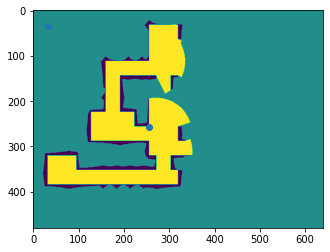

showing frontier
appending 0.0 0.0
appending 0.0 0.65
appending 0.8227780967815204 0.5851163227180652
appending 0.0 0.6583333333333333
appending 0.125 0.3771236166328254
appending 0.25 0.25
appending last 3.141592653589793 61.0


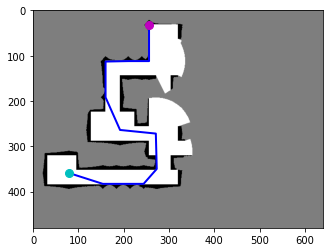

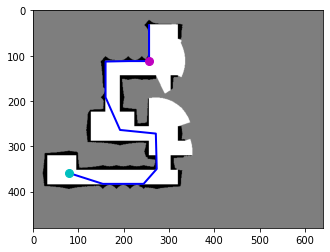

collided??


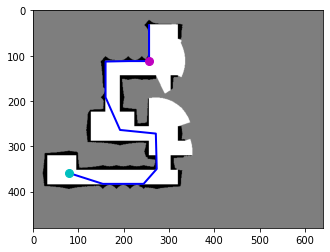

collided??


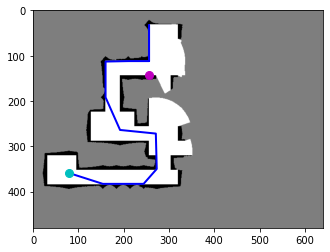

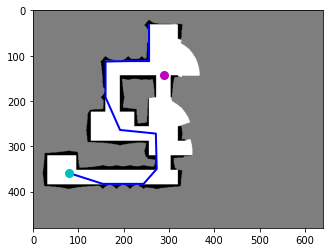

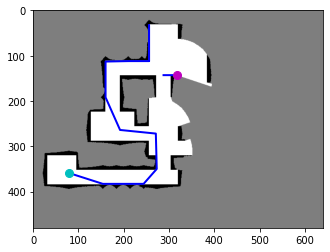

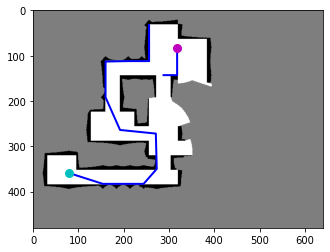

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([1.4670e-33, 8.9087e-35]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.6625, 0.1281]), 'reward': tensor([0.1374]), 'action': tensor([0.5000, 0.5083])}
terminal False
re

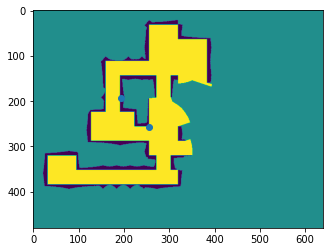

showing frontier
appending 0.0 0.0
appending 0.9369616807080767 0.9935905707192586
appending last 4.778957144160513 15.033296378372908


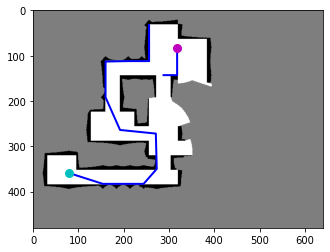

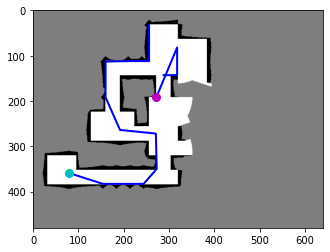

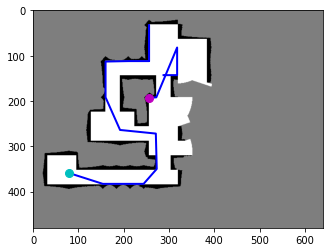

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([3.0562e-36, 1.3920e-37]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.5354, 0.3016]), 'reward': tensor([-0.8000]), 'action': tensor([0.7606, 0.1253])}
terminal False
r

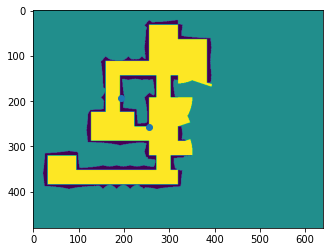

showing frontier
appending 0.0 0.0
appending 0.08394955074184067 0.9933459171462432
appending 0.9129758531449884 0.22438186696393767
appending 0.0 0.25
appending last 1.5707963267948966 13.0


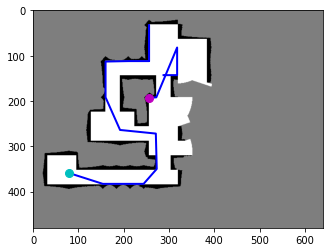

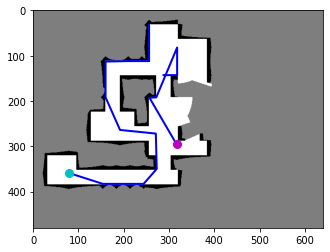

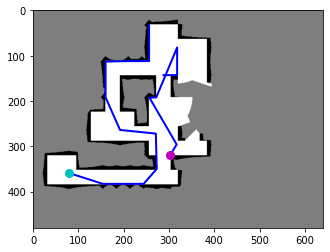

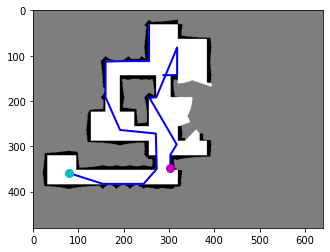

collided??


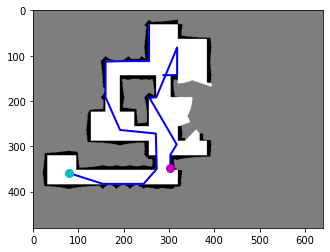

test action {'last_map': tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]), 'last_position': tensor([6.3675e-39, 2.1726e-40]), 'map': tensor([[0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        ...,
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
        [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]), 'position': tensor([0.6313, 0.5453]), 'reward': tensor([-1.]), 'action': tensor([0.2500, 0.1083])}
terminal True
reward

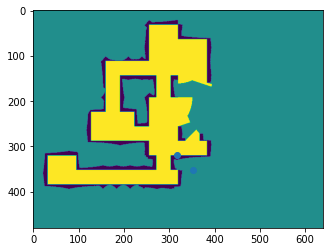

showing frontier


In [41]:
test_policy = GuidedExplorationPolicy(1, None, action_space, 0.2)

reward = 0

test_map, test_position = test_replay.test_env.reset()
test_map = resize(test_map, (168, 168))
test_map = test_map / 255
test_position = test_position.astype(np.float64)
test_position[0] = test_position[0] / 480
test_position[1] = test_position[1] / 640
test_action = {'map':torch.from_numpy(test_map).float(), 'position':torch.from_numpy(test_position).float()}
x = 0

total_reward = 0
while x < 300:

    frontires = test_replay.test_env.frontier(test_replay.test_env.op_map, test_replay.test_env.map_size, test_replay.test_env.t)
    test_action, test_terminal = test_replay.generate_step(test_policy, test_action, add_noise=False, store=False, test=True)
    print('test action', test_action)
    print('terminal', test_terminal)
    print('reward', test_action['reward'])
    total_reward += test_action['reward'].item()
    test_map = test_action['map']
    plt.imshow(test_replay.test_env.op_map)
    plt.scatter(frontires[0, :], frontires[1, :])
 
    plt.show()
    print('showing frontier')
    test_map = resize(test_map, (168, 168))
    test_map = test_map / 255
    test_position = test_position.astype(np.float64)
    test_position[0] = test_position[0] / 480
    test_position[1] = test_position[1] / 640
    test_action = {'map':torch.from_numpy(test_map).float(), 'position':torch.from_numpy(test_position).float()}
    if test_terminal:
        break
    x += 1

In [22]:
test_map, test_position = test_replay.test_env.reset()
import cv2

def getfrontier(data, position):
	w=data.shape[1]
	h=data.shape[0]
	resolution=mapData.info.resolution
	Xstartx=position[1]
	Xstarty=position[0]
	 
	img = np.zeros((h, w, 1), np.uint8)
	
	for i in range(0,h):
		for j in range(0,w):
			if data[i*w+j]==100:
				img[i,j]=0
			elif data[i*w+j]==0:
				img[i,j]=255
			elif data[i*w+j]==-1:
				img[i,j]=205
	
	
       	o=cv2.inRange(img,0,1)
	edges = cv2.Canny(img,0,255)
	im2, contours, hierarchy = cv2.findContours(o,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
	cv2.drawContours(o, contours, -1, (255,255,255), 5)
	o=cv2.bitwise_not(o) 
	res = cv2.bitwise_and(o,edges)
	#------------------------------

	frontier=copy(res)
	im2, contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
	cv2.drawContours(frontier, contours, -1, (255,255,255), 2)

	im2, contours, hierarchy = cv2.findContours(frontier,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
	all_pts=[]
	if len(contours)>0:
		upto=len(contours)-1
		i=0
		maxx=0
		maxind=0
		
		for i in range(0,len(contours)):
				cnt = contours[i]
				M = cv2.moments(cnt)
				cx = int(M['m10']/M['m00'])
				cy = int(M['m01']/M['m00'])
				xr=cx*resolution+Xstartx
				yr=cy*resolution+Xstarty
				pt=[np.array([xr,yr])]
				if len(all_pts)>0:
					all_pts=np.vstack([all_pts,pt])
				else:
							
					all_pts=pt
	
	return all_pts


pts = findFrontier(test_map)
print(pts)
plt.imshow(test_map)
plt.scatter(pts[:, 0], pts[:, 1])

TabError: ignored

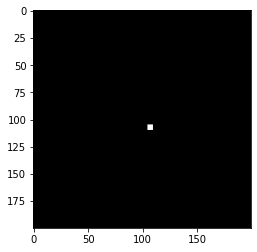

In [ ]:
test = np.zeros((200, 200))
test[5:10, 5:10] = 255
plt.imshow(np.roll(test, (100, 100), [0, 1]), cmap='gray')

In [ ]:
reward_func = PaperRewardFunction()
action_space = PolarActionSpace(30, 60)

if laptop:
    robot = Robot(0, True, False, 'DungeonMaps',action_space,reward_func, False)
    test_robot = Robot(0, True, True, 'DungeonMaps',action_space,reward_func, False)
else:
    robot = Robot(0, True, False, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)
    test_robot = Robot(0, True, True, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)

In [ ]:
replay = Replay(10000, 1000, 300, 4, 2, robot, test_robot, 640, 480)

In [ ]:
linear_dims = [(256, 1)]
actor_linear_dims = [(512, 2)]
conv_dims = [(1, 64, 8), (2, 2), (64, 128, 8), (2, 2), (128, 256, 8), (2, 2)]
lstm_hidden = 512
lstm_out = 2
train_length = 4


ddpg = DDPG(robot, conv_dims, lstm_hidden, linear_dims, actor_linear_dims, train_length, replay, 3e-4, 1e-10, 0.99, 300)

In [ ]:
ddpg.train(10000)

In [ ]:
ddpg.actor(torch.randn(1, 1, 84, 84).to(device='cuda'), torch.randn(1, 2).to(device='cuda'))

In [ ]:
reward = 0

test_map, test_position = replay.test_env.reset()
test_map = resize(test_map, (168, 168))
test_map = test_map / 255
test_position = test_position.astype(np.float64)
test_position[0] = test_position[0] / 480
test_position[1] = test_position[1] / 640
test_action = {'map':torch.from_numpy(test_map).float(), 'position':torch.from_numpy(test_position).float()}
x = 0
total_reward = 0
while x < 300:
    test_action, test_terminal = replay.generate_step(ActorPolicy(ddpg.actor), test_action, add_noise=False, store=False, test=True)
    print('action', test_action)
    print('terminal', test_terminal)
    total_reward += test_action['reward'].item()
    test_map = resize(test_map, (168, 168))
    test_map = test_map / 255
    test_position = test_position.astype(np.float64)
    test_position[0] = test_position[0] / 480
    test_position[1] = test_position[1] / 640
    test_action = {'map':torch.from_numpy(test_map).float(), 'position':torch.from_numpy(test_position).float()}
    if test_terminal:
        break
    x += 1

In [ ]:
init_policy = lambda map, pos, lengths: (torch.from_numpy(np.random.uniform(0, 1, (2,))).unsqueeze(0).unsqueeze(1), None, [1])
ddpg.action_space = action_space
ddpg.replay.generate_episode(init_policy, False, False, True, True)

In [ ]:
np.sum(ddpg.replay.env.global_map == 255)

In [ ]:
640 * 480

In [ ]:
test = nn.Linear(512, 2)

vec = torch.randn(1, 1, 512)

test(vec).size()

In [ ]:
fdfafdsfds